In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion

TRAIN_DIR = 'train'
TEST_DIR = 'test'
IMG_SIZE = 100
LR = 1e-3

MODEL_NAME = 'CNNcancer-{}-{}.model'.format(LR, '6conv-basic') # just so we remember which saved model is which, sizes must match

In [2]:
def label_img(img):
    word_label = img.split('.')[0]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'norm': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'risk': return [0,1]

Now, we can build another function to fully process the training images and their labels into arrays:

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

Now, we can run the training:

In [5]:
train_data = create_train_data()
# If you have already created the dataset:
#train_data = np.load('train_data.npy')

100%|████████████████████████████████████████| 180/180 [00:01<00:00,  6.67it/s]


# Convolutional Neural Network

Next, we're ready to define our neural network:

In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Scipy not supported!


What we have here is a nice, 2 layered convolutional neural network, with a fully connected layer, and then the output layer. It's been debated whether or not a fully connected layer is of any use. I'll leave it in anyway. 

This exact convnet was good enough for recognizing hand 28x28 written digits. Let's see how it does with cats and dogs at 50x50 resolution. 

In [7]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

Now, let's split out training and testing data:

In [8]:
train = train_data[:-10]
test = train_data[-10:]

In [9]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

Now we fit for 3 epochs:

In [10]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
snapshot_step=10, show_metric=True, run_id=MODEL_NAME)

Training Step: 29  | total loss: 11.53251 | time: 2.260s
| Adam | epoch: 010 | loss: 11.53251 - acc: 0.4991 -- iter: 128/170
Training Step: 30  | total loss: 11.44266 | time: 4.735s
| Adam | epoch: 010 | loss: 11.44266 - acc: 0.5031 | val_loss: 11.51293 - val_acc: 0.5000 -- iter: 170/170
--


We could keep trying, but, if you haven't made accuracy progress in the first 3 epochs, you're probably not going to at all, unless it's due to overfitment...at least in my experience. 

So... now what?

# Size Matters #
We're gonna need a bigger network

First, we need to reset the graph instance, since we're doing this in a continuous environment:

In [11]:
import tensorflow as tf
tf.reset_default_graph()

In [12]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-10]
test = train_data[-10:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=10, show_metric=True, run_id=MODEL_NAME)

Training Step: 29  | total loss: 0.64849 | time: 2.328s
| Adam | epoch: 010 | loss: 0.64849 - acc: 0.6168 -- iter: 128/170
Training Step: 30  | total loss: 0.62444 | time: 4.801s
| Adam | epoch: 010 | loss: 0.62444 - acc: 0.6484 | val_loss: 0.44074 - val_acc: 0.8000 -- iter: 170/170
--


In [13]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\rakib\Desktop\try\Final\CNNcancer-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


Now we can reload the model, and continue training (we don't NEED to reload the model here since this is continuous and the model is still in memory, but if you were running this as a program you would)

In [14]:
import tensorflow as tf
tf.reset_default_graph()

In [15]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('C:/Users/rakib/Desktop/1st try/CNNcancer-0.001-2conv-basic.model/{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-10]
test = train_data[-10:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=10, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 29  | total loss: 0.67473 | time: 2.830s
| Adam | epoch: 010 | loss: 0.67473 - acc: 0.5747 -- iter: 128/170
Training Step: 30  | total loss: 0.67011 | time: 5.656s
| Adam | epoch: 010 | loss: 0.67011 - acc: 0.5903 | val_loss: 0.55701 - val_acc: 0.9000 -- iter: 170/170
--
INFO:tensorflow:C:\Users\rakib\Desktop\try\Final\CNNcancer-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


# Visually inspecting our network against unlabeled data #

100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 185.07it/s]


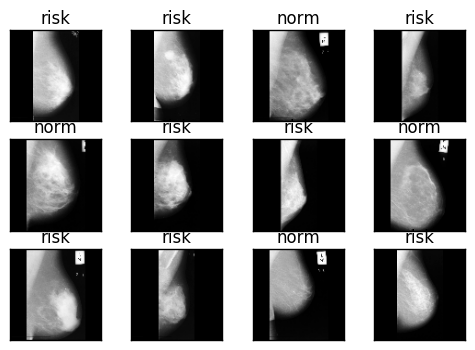

In [16]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # norm: [1,0]
    # risk: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='risk'
    else: str_label='norm'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

Alright, so we made a couple mistakes, but not too bad actually! 



100%|██████████████████████████████████████████| 35/35 [00:00<00:00, 73.64it/s]


In [18]:
#tensorboard --logdir=